# Predicting Insurance Response using Random Forest Classifier

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning

In [20]:
insurance = pd.read_csv('insurance.csv')
insurance.head()
insurance_copy = insurance.copy().drop(['ID', 'Lower_Age'],axis=1)

In [21]:
insurance_copy['Health Indicator'].fillna(insurance_copy['Health Indicator'].mode()[0], inplace = True)
insurance_copy['Holding_Policy_Duration'].replace(('14+'), (14.0), inplace = True)
insurance_copy['Holding_Policy_Duration'] = insurance_copy['Holding_Policy_Duration'].astype('float32')
insurance_copy['Holding_Policy_Duration'].fillna(insurance_copy['Holding_Policy_Duration'].median(), inplace = True)
insurance_copy['Holding_Policy_Type'].fillna(insurance_copy['Holding_Policy_Type'].mode()[0], inplace = True)


We see that there are quite a few null values in this dataset. Lets fillna these values using the mode.

In [22]:
insurance_copy

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,No,X1,14.0,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,No,X2,5.0,3.0,22,30510.0,0
2,C5,3732,Owned,Individual,32,No,X1,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,No,X1,14.0,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50877,C4,845,Rented,Individual,22,No,X3,5.0,3.0,18,7704.0,0
50878,C5,4188,Rented,Individual,27,No,X3,7.0,3.0,4,5408.0,0
50879,C1,442,Rented,Individual,63,No,X2,14.0,1.0,12,11374.0,0
50880,C1,4,Owned,Joint,71,No,X2,2.0,2.0,16,28179.2,1


In [23]:
insurance_copy['Is_Spouse'] = insurance_copy['Is_Spouse'].apply(lambda x: 1 if x =='Yes' else 0)
insurance_copy['Reco_Insurance_Type'] = insurance_copy['Reco_Insurance_Type'].apply(lambda x: 1 if x=='Joint' else 0)
insurance_copy.drop('Reco_Insurance_Type', axis=1, inplace=True)


In [24]:
insurance_copy['Accomodation_Type'].replace(('Owned','Rented'), (0,1), inplace = True)


In [25]:
insurance_copy['Health Indicator'].value_counts()

X1    24701
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [26]:
insurance_copy['City_Code'].value_counts()

C1     8973
C2     7747
C3     4889
C4     3671
C9     2185
C6     1950
C7     1910
C8     1806
C10    1611
C5     1364
C15    1186
C17    1159
C11    1147
C16    1135
C13    1005
C20     926
C19     899
C12     868
C18     797
C14     746
C21     679
C23     587
C24     553
C22     516
C26     499
C29     387
C25     366
C27     295
C33     286
C28     285
C32     160
C34     130
C30      58
C35      56
C36      36
C31      15
Name: City_Code, dtype: int64

In [27]:
# Grouping X6,X7,X8,X9 into a single group due to low value count
insurance_copy['Health Indicator'].replace(('X1','X2','X3','X4','X5','X6','X7','X8','X9'), (0,1,2,3,4,4,4,4,4), inplace = True)

# Grouping 10 areas into 1 area
insurance_copy['City_Code'].replace(('C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',
                           'C11','C12','C13','C14','C15','C16','C17','C18','C19','C20',
                           'C21','C22','C23','C24','C25','C26','C27','C28','C29','C30',
                           'C31','C32','C33','C34','C35','C36'), (0,0,0,0,0,0,0,0,0,0,
                                                            1,1,1,1,1,1,1,1,1,1,
                                                            2,2,2,2,2,2,2,2,2,2,
                                                            3,3,3,3,3,3), inplace = True)


## Preprocessing

In [28]:
X = insurance_copy.drop('Response',axis=1)
y = insurance_copy['Response']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_curve, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
# Over Sampling
sm = SMOTE(random_state = 0)
x_osam , y_osam = sm.fit_resample(X_scaled, y)

In [32]:
x_osam = pd.DataFrame(x_osam, columns=X.columns)
y_osam = pd.Series(y_osam)

## Feature Selection

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector


In [34]:
X_train, X_test, y_train, y_test = train_test_split(x_osam, y_osam, test_size = 0.2, random_state = 42)

In [35]:
from sklearn.ensemble import RandomForestClassifier
model_sfs = RandomForestClassifier(n_estimators = 3, criterion = 'entropy', max_depth = 3,
                               max_features = X_train.shape[1])


In [36]:
sfs = SequentialFeatureSelector(estimator=model_sfs, n_features_to_select=4,direction='forward')
sfs.fit(X_train,y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(criterion='entropy',
                                                           max_depth=3,
                                                           max_features=10,
                                                           n_estimators=3),
                          n_features_to_select=4)

In [37]:
features = sfs.get_feature_names_out()

## RFC

In [38]:
model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 30,
                               max_features = X_train.shape[1])


In [39]:
model.fit(X_train[features], y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, max_features=10)

Text(0, 0.5, 'True Positive rate')

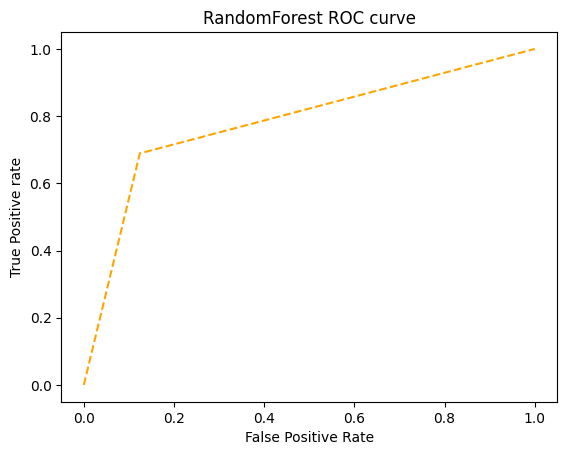

In [42]:
# ROC Curve
y_pred = model.predict(X_test[features])
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Random Forest')
plt.title('RandomForest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

In [43]:
model.score(X_test[features], y_test)

0.7826115061409179

In [44]:
confusion = confusion_matrix(y_pred, y_test)
print(confusion)
print(f"Classification Report:\n {classification_report(y_test, y_pred)}\n")


[[6787 2400]
 [ 963 5320]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.80      7750
           1       0.85      0.69      0.76      7720

    accuracy                           0.78     15470
   macro avg       0.79      0.78      0.78     15470
weighted avg       0.79      0.78      0.78     15470




We have good accuracy as well as good sensitivity/specificity. Our ROC curve looks promising and think that with a little bit of further hyperparameter tuning, could probably obtain a test accuracy > 0.80. SMOTE definitely led to an imrp